In [2]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import random
seed=50
random.seed(seed)

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 400 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=torch.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [3]:
def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=torch.min(data)
    maxx=torch.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(torch.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

In [3]:
def data_gen(batch_size, sim_length,**args):
    args['tsteps'] = sim_length
    N = args['N']
    dt = args['dt']
    args['T'] = int(sim_length*dt)
    # note that time steps = T/dt, dt=0.1
    control_scales = [0, 0.1, 0.01]
    while True:
        data = torch.zeros((batch_size, sim_length, 2, N))
        controls = torch.zeros((batch_size, sim_length, N))

        for b in range(batch_size):
            init = functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,sim_length,d,dt,parameters,realizations,noise)# (2,N)
            args['node_ic'] = init
            control_scale = random.choice(control_scales)
            randcontrol = torch.rand((sim_length,N))*control_scale
            controls[b, :, :] = randcontrol
            data[b, :, :, :] = functions.plot_runge_kutta(functions.ODE_FHN_network,randcontrol, **args) # gives time seris of legth sim_length

        # To return all the data at once
        # yield(data)

        # To return the data in chunks of length L
        L = 10
        num_chunks = sim_length // L
        for i in range(num_chunks):
            yield(data[:, i*L : (i+1)*L, :, :], controls[:, i*L : (i+1)*L, :])

In [4]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.

        return src[:, 0] * edge_attr

class NodeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        control_features = 1
        in_channels = 2+1 
        hiddens = 2*in_channels
        self.node_mlp = Sequential(
            nn.Linear(in_channels, hiddens),
            nn.ReLU(),
            nn.Linear(hiddens, in_channels),
            nn.ReLU(),
            nn.Linear(in_channels, control_features))

        
    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out.unsqueeze(1)], dim=1)
        return self.node_mlp(out.clone()).squeeze(1)

In [4]:
def R(x, alpha , beta, gamma):
    return -alpha* x**3 + beta *x**2 - gamma* x 

def ODE_FHN_network(x,control, tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A):

    out=torch.zeros(x.shape)
    Coupling = torch.matmul(A,x[0])
    out[0]= R(x[0], alpha , beta, gamma) - x[1] + mu + control + sigma * Coupling
    out[1]= (1/tau)* (x[0] + delta  - epsilon* x[1])
    #Coupling = torch.matmul(A, x[0])
    #x0_out = R(x[0], alpha, beta, gamma) - x[1] + mu + sigma * Coupling + control 
    #x1_out = (1/tau) * (x[0] + delta - epsilon * x[1])
    
    return out#torch.stack([x0_out, x1_out], dim=0)#out

def FHN_next_step(current, control,ODE_FHN_network, **args): 
    #1. load args
    tsteps = args['tsteps'] #timesteps, int
    dt = args['dt'] #stepsize of timesteps, float
    N = args['N'] #number of nodes, int
    d = args['d'] #dimension of oscillator dynamnode_ics, int
    alpha = args['alpha'] #parameter of FHN oscillator, float
    beta = args['beta'] #parameter of FHN oscillator, float
    gamma = args['gamma'] #parameter of FHN oscillator, float
    delta = args['delta'] #parameter of FHN oscillator, float
    epsilon = args['epsilon'] #parameter of FHN oscillator, float
    tau = args['tau'] #parameter of FHN oscillator, float
    mu = args['mu'] #parameter of FHN oscillator, float
    sigma = args['sigma'] #parameter of FHN oscillator, float
    A = args['A'] #adjacency matrix, array shape(N,N)

    #current = current.detach()
    k1 = dt* ODE_FHN_network(current,control,tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
    k2 = dt* ODE_FHN_network(current + k1/2 , control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
    k3 = dt* ODE_FHN_network(current + k2/2 , control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
    k4 = dt* ODE_FHN_network(current + k3 , control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu, sigma, A)
    #k1 = k1.detach()
    #k2 = k2.detach()
    #k3 = k3.detach()
    #k4 = k4.detach()
    next_state = current.clone() + (1/6)* (k1 + 2*k2 + 2*k3 + k4)
    return next_state

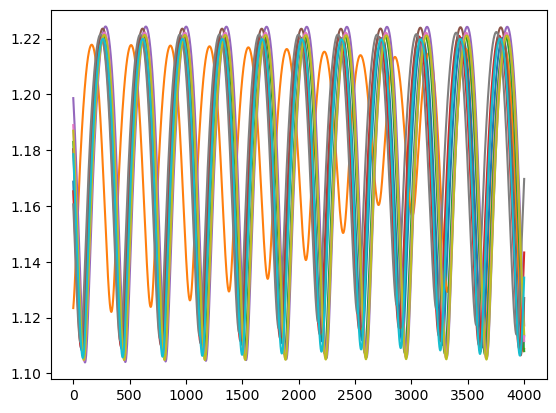

In [6]:
current_state = node_ic.clone()
controlled_states = [current_state.unsqueeze(0)]
for t in range(tsteps):
    control = torch.zeros(10) 
    next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args) 
    current_state = next_state.detach() 
    controlled_states.append(current_state.unsqueeze(0))
    
sample_states = torch.cat(controlled_states, dim=0)
plt.plot(sample_states[:,1,:])
plt.show()

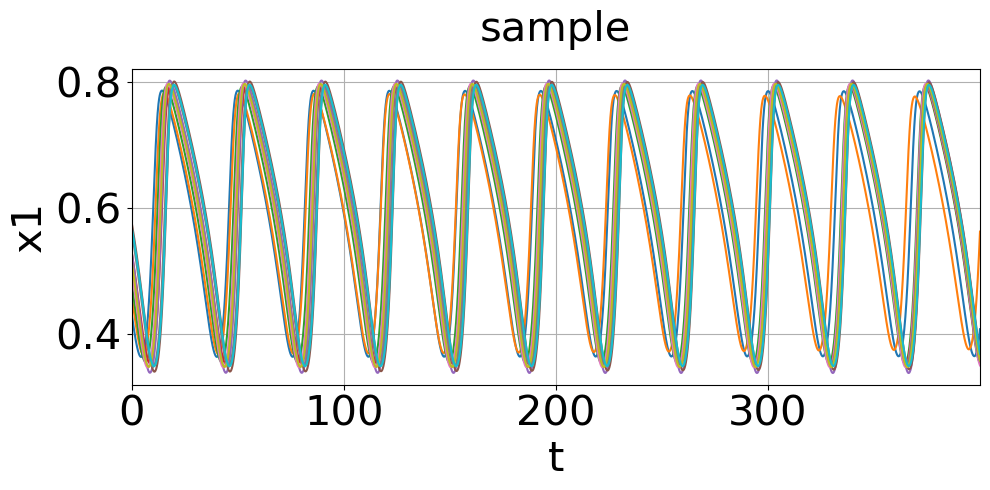

In [52]:
create_plot(sample_states[1:,0,:],'x1','sample')

In [10]:
sample_cc = cross_correlation_matrix(sample_states[:,0,:] , tsteps , args['N'])

In [46]:
sample_cc

tensor([[1.0000, 0.9666, 0.8587, 0.7060, 0.6192, 0.4292, 0.7933, 0.5794, 0.7099,
         0.4614],
        [0.9666, 1.0000, 0.7680, 0.6162, 0.5196, 0.3314, 0.7017, 0.4877, 0.6135,
         0.3639],
        [0.8587, 0.7680, 1.0000, 0.9570, 0.9240, 0.7917, 0.9915, 0.8852, 0.9654,
         0.8133],
        [0.7060, 0.6162, 0.9570, 1.0000, 0.9875, 0.9266, 0.9856, 0.9805, 0.9956,
         0.9395],
        [0.6192, 0.5196, 0.9240, 0.9875, 1.0000, 0.9558, 0.9635, 0.9822, 0.9914,
         0.9648],
        [0.4292, 0.3314, 0.7917, 0.9266, 0.9558, 1.0000, 0.8579, 0.9786, 0.9164,
         0.9993],
        [0.7933, 0.7017, 0.9915, 0.9856, 0.9635, 0.8579, 1.0000, 0.9346, 0.9901,
         0.8759],
        [0.5794, 0.4877, 0.8852, 0.9805, 0.9822, 0.9786, 0.9346, 1.0000, 0.9677,
         0.9849],
        [0.7099, 0.6135, 0.9654, 0.9956, 0.9914, 0.9164, 0.9901, 0.9677, 1.0000,
         0.9299],
        [0.4614, 0.3639, 0.8133, 0.9395, 0.9648, 0.9993, 0.8759, 0.9849, 0.9299,
         1.0000]])

In [55]:
target_anticc = sample_cc.clone()
pairs = [(i, j) for i in range(10) for j in range(i+1, 10)]
selected_pairs = torch.tensor(random.sample(pairs, 10))

# Set the selected elements to -1
for i, j in selected_pairs:
    target_anticc[i, j] = target_anticc[j, i] = -1

print(target_anticc)

tensor([[ 1.0000,  0.9666,  0.8587,  0.7060,  0.6192,  0.4292, -1.0000,  0.5794,
          0.7099,  0.4614],
        [ 0.9666,  1.0000,  0.7680,  0.6162,  0.5196,  0.3314,  0.7017,  0.4877,
         -1.0000,  0.3639],
        [ 0.8587,  0.7680,  1.0000, -1.0000,  0.9240,  0.7917, -1.0000, -1.0000,
          0.9654, -1.0000],
        [ 0.7060,  0.6162, -1.0000,  1.0000,  0.9875,  0.9266,  0.9856,  0.9805,
          0.9956,  0.9395],
        [ 0.6192,  0.5196,  0.9240,  0.9875,  1.0000, -1.0000, -1.0000,  0.9822,
          0.9914, -1.0000],
        [ 0.4292,  0.3314,  0.7917,  0.9266, -1.0000,  1.0000,  0.8579,  0.9786,
          0.9164,  0.9993],
        [-1.0000,  0.7017, -1.0000,  0.9856, -1.0000,  0.8579,  1.0000,  0.9346,
         -1.0000,  0.8759],
        [ 0.5794,  0.4877, -1.0000,  0.9805,  0.9822,  0.9786,  0.9346,  1.0000,
          0.9677,  0.9849],
        [ 0.7099, -1.0000,  0.9654,  0.9956,  0.9914,  0.9164, -1.0000,  0.9677,
          1.0000,  0.9299],
        [ 0.4614,  

In [56]:
args['target_output'] = target_anticc

In [60]:
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

functional=functions.f_sync_torch
gradient=functions.fprime_sync_torch

from opt_pytorch import FR_algorithm
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
while warnflag == 1 and iteration<5000:
    
    result = FR_algorithm(functional, control, gradient,**args)

    control=result[0]
    warnflag=result[2]
    iteration+=result[4]
    
    #make dictionary to save the result
    out={
        'optimal_control':control.reshape(tsteps,parameters['N']),
        'functional':result[1],
        'gradient_norm':result[3],
        'warnflag':result[2],
        'iterations':iteration,
        'node_ic':node_ic,
        'target_output':target_output,
        'external_current':parameters['mu'],
        'coupling_strength':parameters['sigma'],
        'noise_strength':noise_strength,
        'noise':noise,
        'I_p':I_p,
        'I_e':I_e,
        'I_s':I_s,
        'T':T,
        'bifurcation':bifurcation,
        'goal':goal
        }
    
    print('Iteration ',iteration,' finished at gnorm',result[3],'with f',result[1],'with warnflag',result[2])
print('Code finished after ',iteration,' iterations with warnflag',result[2])  

tensor([0.0019, 0.0017, 0.0018,  ..., 0.0011, 0.0011, 0.0011],
       requires_grad=True) tensor(0.0345, grad_fn=<AddBackward0>) tensor([0.0020, 0.0027, 0.0005,  ..., 0.0011, 0.0011, 0.0011])
tensor([0.0019, 0.0017, 0.0018,  ..., 0.0011, 0.0011, 0.0011],
       grad_fn=<AddBackward0>) tensor(0.0345, grad_fn=<AddBackward0>) tensor([0.0020, 0.0027, 0.0005,  ..., 0.0011, 0.0011, 0.0011])
tensor([-0.0012, -0.0025,  0.0010,  ..., -0.0006, -0.0006, -0.0006],
       grad_fn=<AddBackward0>) tensor(0.0176, grad_fn=<AddBackward0>) tensor([-0.0015, -0.0027,  0.0003,  ..., -0.0006, -0.0006, -0.0006])
tensor([-0.0012, -0.0025,  0.0010,  ..., -0.0006, -0.0006, -0.0006],
       grad_fn=<AddBackward0>) tensor(0.0176, grad_fn=<AddBackward0>) tensor([-0.0015, -0.0027,  0.0003,  ..., -0.0006, -0.0006, -0.0006])
tensor([0.0011, 0.0017, 0.0005,  ..., 0.0004, 0.0004, 0.0004],
       grad_fn=<AddBackward0>) tensor(0.0129, grad_fn=<AddBackward0>) tensor([ 0.0011,  0.0025, -0.0005,  ...,  0.0004,  0.0004,  0.0

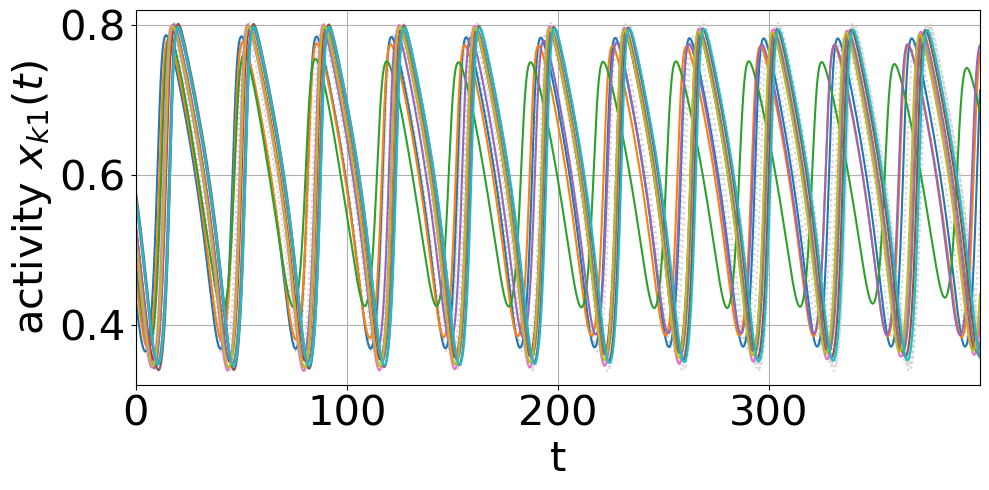

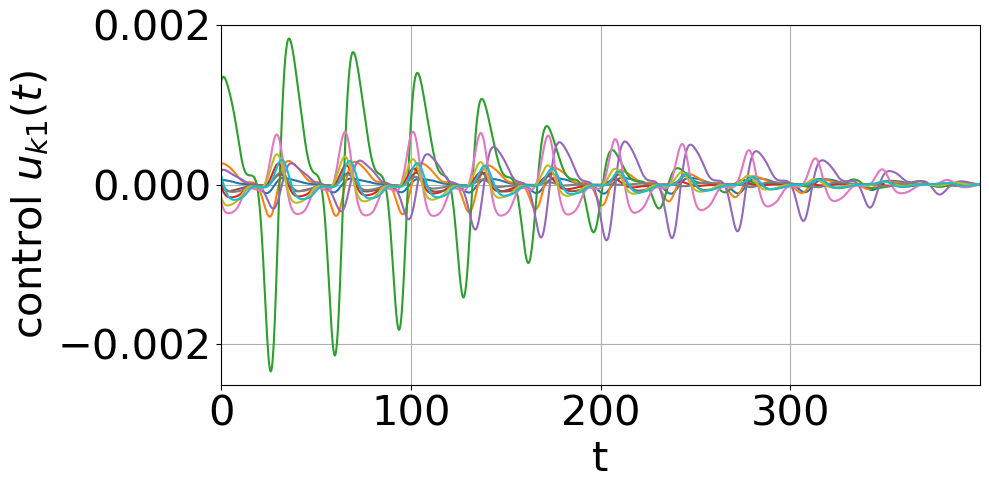

In [61]:
######################### PLOT THE RESULTS ############################


import matplotlib.pyplot as plt
from pylab import figure, cm


#calculate the controlled and uncontrolled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control.detach(), **args)
nocontrol=torch.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

#make plot
fs=30 #fontsize
i=-1
# PLOT NETWORK STATE
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=torch.min(state_controlled[:,0,:])
maxx=torch.max(state_controlled[:,0,:])
add=(maxx-minn)/25
im1=ax.plot(torch.arange(0,int(T),dt),state_uncontrolled[:,0,:],color='lightgray',linestyle='dotted')
ax.plot(torch.arange(0,int(T),dt),state_controlled[:,0,:])
ax.set_xlabel('t',size=fs)
ax.set_ylabel('activity $x_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Network state',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()


# PLOT CORRESPONDING OPTIMAL CONTROL
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

# set min and max for scope of y-axis
minn=torch.min(control.detach())
maxx=torch.max(control.detach())
add=(maxx-minn)/25

im1=ax.plot(torch.arange(0,int(T),dt),control.detach())
ax.set_xlabel('t',size=fs)
ax.set_ylabel('control $u_{k1}(t)$',size=fs)
ax.set_ylim(minn-add,maxx+add)
#ax.set_title('Control',size=fs, pad=20)
ax.tick_params(labelsize=fs)
ax.grid(True)
ax.margins(0) # remove default margins (matplotlib verision 2+)

fig.tight_layout()
plt.show()




In [65]:
cc_controlled = cross_correlation_matrix(state_controlled[:,0,:] , tsteps , args['N'])
print(cc_controlled)

tensor([[ 1.0000,  0.9630,  0.4457,  0.5899,  0.8535,  0.2731,  0.6258,  0.4332,
          0.6284,  0.2069],
        [ 0.9630,  1.0000,  0.6130,  0.4529,  0.8673,  0.1380,  0.4836,  0.2946,
          0.4920,  0.0762],
        [ 0.4457,  0.6130,  1.0000, -0.0871,  0.3970, -0.2999, -0.0555, -0.2069,
         -0.0583, -0.3212],
        [ 0.5899,  0.4529, -0.0871,  1.0000,  0.6898,  0.9145,  0.9928,  0.9765,
          0.9966,  0.8725],
        [ 0.8535,  0.8673,  0.3970,  0.6898,  1.0000,  0.4478,  0.6858,  0.5811,
          0.7129,  0.3837],
        [ 0.2731,  0.1380, -0.2999,  0.9145,  0.4478,  1.0000,  0.8820,  0.9782,
          0.8865,  0.9924],
        [ 0.6258,  0.4836, -0.0555,  0.9928,  0.6858,  0.8820,  1.0000,  0.9521,
          0.9967,  0.8410],
        [ 0.4332,  0.2946, -0.2069,  0.9765,  0.5811,  0.9782,  0.9521,  1.0000,
          0.9588,  0.9496],
        [ 0.6284,  0.4920, -0.0583,  0.9966,  0.7129,  0.8865,  0.9967,  0.9588,
          1.0000,  0.8413],
        [ 0.2069,  

In [66]:
cc_uncontrolled = cross_correlation_matrix(state_uncontrolled[:,0,:] , tsteps , args['N'])
print(cc_uncontrolled)

tensor([[1.0000, 0.9667, 0.8586, 0.7059, 0.6191, 0.4290, 0.7932, 0.5792, 0.7098,
         0.4611],
        [0.9667, 1.0000, 0.7681, 0.6163, 0.5197, 0.3315, 0.7019, 0.4878, 0.6136,
         0.3640],
        [0.8586, 0.7681, 1.0000, 0.9569, 0.9240, 0.7916, 0.9915, 0.8852, 0.9654,
         0.8132],
        [0.7059, 0.6163, 0.9569, 1.0000, 0.9875, 0.9265, 0.9856, 0.9805, 0.9956,
         0.9395],
        [0.6191, 0.5197, 0.9240, 0.9875, 1.0000, 0.9558, 0.9634, 0.9822, 0.9914,
         0.9648],
        [0.4290, 0.3315, 0.7916, 0.9265, 0.9558, 1.0000, 0.8579, 0.9786, 0.9164,
         0.9993],
        [0.7932, 0.7019, 0.9915, 0.9856, 0.9634, 0.8579, 1.0000, 0.9346, 0.9901,
         0.8758],
        [0.5792, 0.4878, 0.8852, 0.9805, 0.9822, 0.9786, 0.9346, 1.0000, 0.9677,
         0.9849],
        [0.7098, 0.6136, 0.9654, 0.9956, 0.9914, 0.9164, 0.9901, 0.9677, 1.0000,
         0.9299],
        [0.4611, 0.3640, 0.8132, 0.9395, 0.9648, 0.9993, 0.8758, 0.9849, 0.9299,
         1.0000]])


In [67]:
print(torch.sum((target_anticc-cc_uncontrolled)**2), torch.sum((target_anticc-cc_controlled)**2))

tensor(71.9153) tensor(44.2358)


In [9]:
def cross_correlation_matrix(x , horizen_length , N):
    means = (1/horizen_length) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

def sync_loss(state,control,horizen_length,N,I_p, I_e, I_s,target_output):
    #control.retain_grad()

    state = state[:,0,:]

    cc = cross_correlation_matrix(state , horizen_length , N)
    f1 =   I_p * (1/4)* torch.sum((cc -   target_output)**2)
    f2=   I_e/2 * (control**2).sum() 
    if   I_s>1e-10:
        controlsum= torch.sum(control**2, dim=0)**(1.0 / 2.0)#
        f3 =   I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

def cc_loss(state,horizen_length,N,target_output):
    state_1 = state[:,0,:]

    cc = cross_correlation_matrix(state_1 , horizen_length , N)
    f1 =   torch.sum((cc -   target_output)**2)
    return f1

In [7]:
adj = torch.ones(n_nodes,n_nodes)
torch.diagonal(adj, 0).zero_()
edge_index = adj.nonzero().t().contiguous()
edge_attr = A[edge_index[0], edge_index[1]]

In [8]:
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
loss_threshold = 1e-4
max_epochs = 200
look_ahead = 10
torch.autograd.set_detect_anomaly(True)

for epoch in range(1):
    epoch_loss = 0
    current_state = node_ic.to(device).clone()
    losses = []
    store_states = torch.zeros(look_ahead,2,n_nodes).to(device)
    for t in range(tsteps):
        control = model(current_state.T, edge_index, edge_attr)[0]
        #print(control)
        next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args)
        #print(next_state)
        store_states[t % look_ahead,:,:] = next_state.clone()
        
        current_state = next_state.clone()

        if t % look_ahead == 0 and t >= look_ahead:
            loss = sync_loss(store_states, look_ahead, n_nodes, I_p, I_e, I_s, target_output)
            losses.append(loss)
            store_states.detach()
            control.detach()

    # Now, process all the computed losses:
    for loss in losses:
        optimizer.zero_grad()  # Clear the gradients
        print('before backward')
        loss.backward()
        optimizer.step()
        print('after backward')
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(losses)
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss}")

    if avg_epoch_loss < loss_threshold:
        print("Stopping criterion reached.")
        break


KeyboardInterrupt: 

In [19]:
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
loss_threshold = 1e-4
max_epochs = 200
look_ahead = 10
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
torch.autograd.set_detect_anomaly(True)
for epoch in range(max_epochs):
    epoch_loss = 0
    current_state = node_ic.to(device).clone()
    store_states = current_state.unsqueeze(0)
    optimizer.zero_grad()
    for t in range(tsteps):
        control = model(current_state.T, edge_index, edge_attr)[0].clone()  # clone the control tensor
        next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args)  # clone the current_state tensor
        store_states = torch.cat((store_states, next_state.unsqueeze(0)), dim=0)
        
        if t % look_ahead == 0 and t >= look_ahead:
            loss = sync_loss(store_states[-look_ahead:,:,:], look_ahead, n_nodes, I_p, I_e, I_s, target_output)  # clone the store_states tensor
            #retain_graph_flag = (t + look_ahead < tsteps)
            print('before')
            loss.backward()#(retain_graph=retain_graph_flag)
            print('after')
            optimizer.step()
            epoch_loss += loss.item()
            store_states.detach()
            control.detach()
            current_state.detach()
            #make_dot(loss).render("computation_graph", format="png")

        current_state = next_state#.detach()  
    avg_epoch_loss = epoch_loss / (tsteps // look_ahead)
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss}")
        


before
after
before


/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/shi/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/shi/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/shi/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/Users/shi/anaconda3/envs/m5r/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/Users/shi/anaconda3/envs/m5r/lib/pyt

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [73]:
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
loss_threshold = 1e-4
max_epochs = 50
look_ahead = 10
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
torch.autograd.set_detect_anomaly(True)
for epoch in range(max_epochs):
    epoch_loss = 0
    current_state = node_ic.to(device).clone()
    for t in range(tsteps):
        optimizer.zero_grad()
        control1 = model(current_state.T, edge_index, edge_attr)[0]  
        next_state1 = FHN_next_step(current_state, control1, ODE_FHN_network, **args)  
        #next_state = next_state.to(device)
        control2 = model(next_state1.T, edge_index, edge_attr)[0]
        next_state2 = FHN_next_step(next_state1, control2, ODE_FHN_network, **args) 
        control3 = model(next_state2.T, edge_index, edge_attr)[0]
        next_state3 = FHN_next_step(next_state2, control3, ODE_FHN_network, **args) 
        control4 = model(next_state3.T, edge_index, edge_attr)[0]
        next_state4 = FHN_next_step(next_state3, control4, ODE_FHN_network, **args) 
        control5 = model(next_state4.T, edge_index, edge_attr)[0]
        next_state5 = FHN_next_step(next_state4, control5, ODE_FHN_network, **args) 
        control6 = model(next_state5.T, edge_index, edge_attr)[0]
        next_state6 = FHN_next_step(next_state5, control6, ODE_FHN_network, **args) 
        control7 = model(next_state6.T, edge_index, edge_attr)[0]
        next_state7 = FHN_next_step(next_state6, control7, ODE_FHN_network, **args) 
        control8 = model(next_state7.T, edge_index, edge_attr)[0]
        next_state8 = FHN_next_step(next_state7, control8, ODE_FHN_network, **args) 
        control9 = model(next_state8.T, edge_index, edge_attr)[0]
        next_state9 = FHN_next_step(next_state8, control9, ODE_FHN_network, **args) 
        control10 = model(next_state9.T, edge_index, edge_attr)[0]
        next_state10 = FHN_next_step(next_state9, control10, ODE_FHN_network, **args) 
        
        loss_states = torch.cat((next_state1.unsqueeze(0), next_state2.unsqueeze(0), next_state3.unsqueeze(0), next_state4.unsqueeze(0)
                                , next_state5.unsqueeze(0), next_state6.unsqueeze(0), next_state7.unsqueeze(0), next_state8.unsqueeze(0)
                                , next_state9.unsqueeze(0), next_state10.unsqueeze(0)), dim=0)
        
        loss = sync_loss(loss_states, control10,10,10,I_p, I_e, I_s,target_anticc)  # clone the store_states tensor
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #store_states.detach()
        #control.detach()
        #current_state.detach()
        current_state = next_state10.detach()  
        
    avg_epoch_loss = epoch_loss / (tsteps // look_ahead)
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss}")
        


Epoch 1/50, Loss: 0.19508809979539365
Epoch 2/50, Loss: 0.14992137380642817
Epoch 3/50, Loss: 0.15486038643866779
Epoch 4/50, Loss: 0.14249965825118124
Epoch 5/50, Loss: 0.15117957677459345
Epoch 6/50, Loss: 0.1568262774683535
Epoch 7/50, Loss: 0.1315337795438245
Epoch 8/50, Loss: 0.15550134734017773
Epoch 9/50, Loss: 0.14929974802769722
Epoch 10/50, Loss: 0.15628529446432368
Epoch 11/50, Loss: 0.1444416393735446
Epoch 12/50, Loss: 0.14448036609217524
Epoch 13/50, Loss: 0.1575294842524454
Epoch 14/50, Loss: 0.15540834561921657
Epoch 15/50, Loss: 0.15151357527589426
Epoch 16/50, Loss: 0.13575590392109008
Epoch 17/50, Loss: 0.14452373061329127
Epoch 18/50, Loss: 0.13941101825796068
Epoch 19/50, Loss: 0.1627088399627246
Epoch 20/50, Loss: 0.15636457123328001
Epoch 21/50, Loss: 0.1448613709025085
Epoch 22/50, Loss: 0.1505117489420809
Epoch 23/50, Loss: 0.15736591664142907
Epoch 24/50, Loss: 0.13794331199955195
Epoch 25/50, Loss: 0.1525389280798845
Epoch 26/50, Loss: 0.13758086200803518
Epo

In [74]:
model.eval()

current_state = node_ic.to(device).clone()
controls = []
controlled_states = [current_state.unsqueeze(0)]
for t in range(tsteps):
    control = model(current_state.T, edge_index, edge_attr)[0]  
    next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args) 
    current_state = next_state.detach() 
    controlled_states.append(current_state.unsqueeze(0))
    controls.append(control.detach().unsqueeze(0))

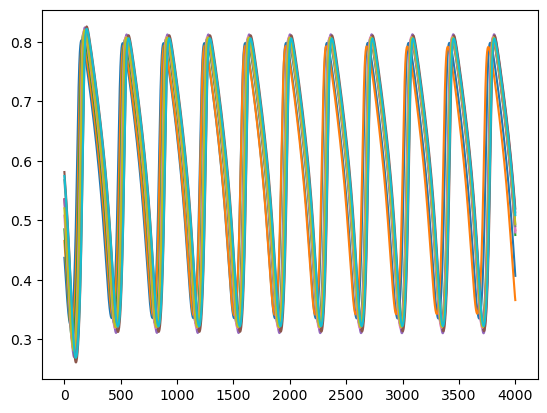

In [77]:
opt_controls = torch.cat(controls, dim=0)
opt_states = torch.cat(controlled_states, dim=0)
plt.plot(opt_states[:,0,:])
#plt.plot(opt_controls)
plt.show()

In [82]:
cc_opt = cross_correlation_matrix(opt_states[-10:,0,:] , 10 , args['N'])
print(cc_opt)

tensor([[1.0000, 0.9996, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
         0.9999],
        [0.9996, 1.0000, 0.9993, 0.9993, 0.9992, 0.9992, 0.9992, 0.9992, 0.9992,
         0.9992],
        [0.9999, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9993, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000],
        [0.9999, 0.9992, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])


In [83]:
print(torch.sum((target_anticc-cc_uncontrolled)**2), torch.sum((target_anticc-cc_opt)**2))

tensor(71.9153) tensor(85.7391)


In [ ]:
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.MSELoss()
loss_threshold = 1e-4
max_epochs = 50
look_ahead = 10
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
torch.autograd.set_detect_anomaly(True)
for epoch in range(max_epochs):
    epoch_loss = 0
    current_state = node_ic.to(device).clone()
    for t in range(tsteps):
        optimizer.zero_grad()
        control1 = model(current_state.T, edge_index, edge_attr)[0]  
        next_state1 = FHN_next_step(current_state, control1, ODE_FHN_network, **args)  
        #next_state = next_state.to(device)
        control2 = model(next_state1.T, edge_index, edge_attr)[0]
        next_state2 = FHN_next_step(next_state1, control2, ODE_FHN_network, **args) 
        control3 = model(next_state2.T, edge_index, edge_attr)[0]
        next_state3 = FHN_next_step(next_state2, control3, ODE_FHN_network, **args) 
        control4 = model(next_state3.T, edge_index, edge_attr)[0]
        next_state4 = FHN_next_step(next_state3, control4, ODE_FHN_network, **args) 
        control5 = model(next_state4.T, edge_index, edge_attr)[0]
        next_state5 = FHN_next_step(next_state4, control5, ODE_FHN_network, **args) 
        control6 = model(next_state5.T, edge_index, edge_attr)[0]
        next_state6 = FHN_next_step(next_state5, control6, ODE_FHN_network, **args) 
        control7 = model(next_state6.T, edge_index, edge_attr)[0]
        next_state7 = FHN_next_step(next_state6, control7, ODE_FHN_network, **args) 
        control8 = model(next_state7.T, edge_index, edge_attr)[0]
        next_state8 = FHN_next_step(next_state7, control8, ODE_FHN_network, **args) 
        control9 = model(next_state8.T, edge_index, edge_attr)[0]
        next_state9 = FHN_next_step(next_state8, control9, ODE_FHN_network, **args) 
        control10 = model(next_state9.T, edge_index, edge_attr)[0]
        next_state10 = FHN_next_step(next_state9, control10, ODE_FHN_network, **args) 
        
        loss_states = torch.cat((next_state1.unsqueeze(0), next_state2.unsqueeze(0), next_state3.unsqueeze(0), next_state4.unsqueeze(0)
                                , next_state5.unsqueeze(0), next_state6.unsqueeze(0), next_state7.unsqueeze(0), next_state8.unsqueeze(0)
                                , next_state9.unsqueeze(0), next_state10.unsqueeze(0)), dim=0)
        
        loss = cc_loss(loss_states,10,10,target_anticc) 
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #store_states.detach()
        #control.detach()
        #current_state.detach()
        current_state = next_state10.detach()  
        
    avg_epoch_loss = epoch_loss / (tsteps // look_ahead)
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss}")
        


Epoch 1/50, Loss: 898.1119365787506
Epoch 2/50, Loss: 870.245249042511
Epoch 3/50, Loss: 873.8108916664123
Epoch 4/50, Loss: 867.7773377132415


### test

In [19]:
model.eval()

current_state = node_ic.to(device).clone()
controls = []
controlled_states = [current_state.unsqueeze(0)]
for t in range(tsteps):
    control = model(current_state.T, edge_index, edge_attr)[0]  
    next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args) 
    current_state = next_state.detach() 
    controlled_states.append(current_state.unsqueeze(0))
    controls.append(control.detach().unsqueeze(0))

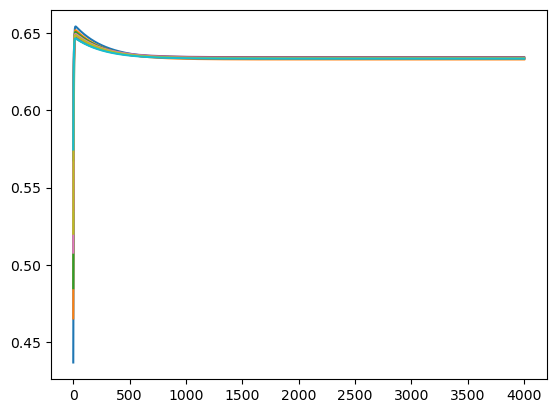

In [23]:
opt_controls = torch.cat(controls, dim=0)
opt_states = torch.cat(controlled_states, dim=0)
plt.plot(opt_states[:,0,:])
#plt.plot(opt_controls)
plt.show()

In [28]:
current_state = node_ic.to(device).clone()
controlled_states = [current_state.unsqueeze(0)]
for t in range(tsteps):
    control = torch.zeros(10) 
    next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args) 
    current_state = next_state.detach() 
    controlled_states.append(current_state.unsqueeze(0))
    
sample_states = torch.cat(controlled_states, dim=0)
plt.plot(sample_states[:,1,:])
plt.show()

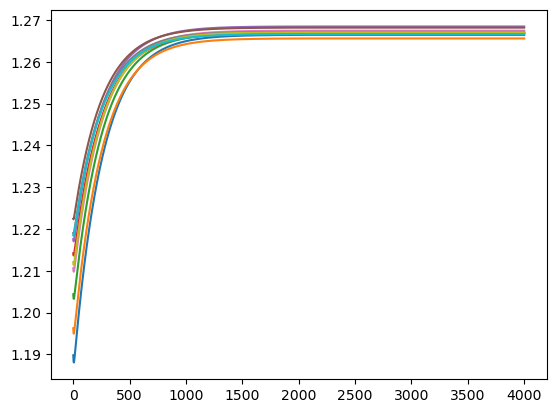

In [30]:
sample_states = torch.cat(controlled_states, dim=0)
plt.plot(sample_states[:,1,:])
plt.show()

In [32]:
nocontrol=torch.zeros((tsteps,parameters['N']))
true_traj = functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

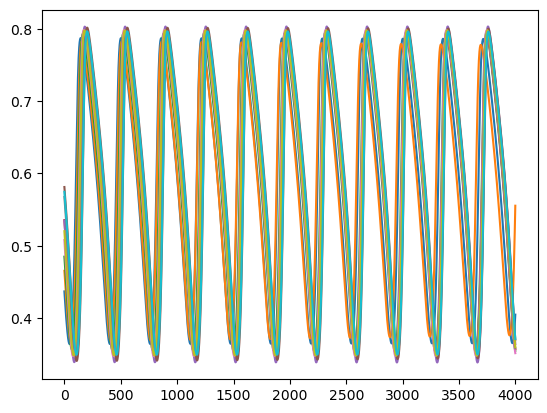

In [33]:
plt.plot(true_traj[:,0,:])
plt.show()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
loss_threshold = 1e-4
max_epochs = 200
look_ahead = 10
torch.autograd.set_detect_anomaly(True)
for epoch in range(max_epochs):
    epoch_loss = 0
    current_state = node_ic.to(device).clone()

    store_states = torch.zeros(look_ahead,2,n_nodes).to(device)
    optimizer.zero_grad()
    for t in range(tsteps):
        control = model(current_state.T.detach(),edge_index.detach(),edge_attr.detach())[0].clone()
        #predict the next state using ground truth dynamics
        next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args) 
        next_state = next_state.to(device)
        store_states[t % look_ahead,:,:] = next_state.clone()
        
        if t%look_ahead == 0 and t >= look_ahead:
            loss = sync_loss(store_states,look_ahead,n_nodes,I_p, I_e, I_s,target_output)
            
            #optimizer.zero_grad()
            #print('before backward')
            retain_graph_flag = (t + look_ahead < tsteps)
            #print(t)
            loss.backward(retain_graph=retain_graph_flag)
            optimizer.step()
            #print('after backward')
            epoch_loss += loss.item()

        current_state = next_state.clone()

    
    avg_epoch_loss = epoch_loss / (tsteps // look_ahead)
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss}")
    
    if avg_epoch_loss < loss_threshold:
        print("Stopping criterion reached.")
        break

/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/shi/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/shi/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/shi/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/Users/shi/anaconda3/envs/m5r/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/Users/shi/anaconda3/envs/m5r/lib/p

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [3, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MetaLayer(EdgeModel(), NodeModel()).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
loss_fn = nn.MSELoss()
loss_threshold = 1e-4
max_epochs = 200
look_ahead = 10
torch.autograd.set_detect_anomaly(True)
for epoch in range(max_epochs):
    epoch_loss = 0
    current_state = node_ic.to(device).clone()

    store_states = torch.zeros(tsteps,2,n_nodes).to(device)
    optimizer.zero_grad()
    for t in range(tsteps):
        control = model(current_state.T,edge_index,edge_attr)[0]  
        #predict the next state using ground truth dynamics
        next_state = FHN_next_step(current_state, control, ODE_FHN_network, **args) 
        next_state = next_state.to(device)
        store_states[t,:,:] = next_state.clone()
        
        if t%look_ahead == 0 and t >= look_ahead:
            states_for_loss = store_states[t-look_ahead+1:t+1:,:,:]
            loss = sync_loss(states_for_loss,look_ahead,n_nodes,I_p, I_e, I_s,target_output)
            
            #optimizer.zero_grad()
            print('before backward')
            retain_graph_flag = (t + look_ahead < tsteps)
            print(t)
            loss.backward(retain_graph=retain_graph_flag)
            optimizer.step()
            print('after backward')
            epoch_loss += loss.item()

        current_state = next_state.clone()

    
    avg_epoch_loss = epoch_loss / (tsteps // look_ahead)
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {avg_epoch_loss}")
    
    if avg_epoch_loss < loss_threshold:
        print("Stopping criterion reached.")
        break

before backward
10
after backward
before backward
20


/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in AddmmBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/shi/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/shi/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/shi/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/Users/shi/anaconda3/envs/m5r/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/Users/shi/anaconda3/envs/m5r/lib/p

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [3, 1]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

## FHN control

In [61]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import func_pytorch as functions
from opt_pytorch import FR_algorithm

import torch
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import random

goal='sync'
bifurcation='high'
noise_strength= 0.0 
realizations=1
noise=0
parameters = functions.set_parameters(goal,bifurcation,parentDir)

# 10 nodes
n_nodes = 10
A = parameters['A'][:n_nodes,:n_nodes]
#A = np.zeros((5,5))
parameters['A'] = A
parameters['N'] = n_nodes


#Set dimensions
T= 100 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set paraeters of the cost functional
I_p_in= 0.0005 #penalize precision
I_e= 1.0 #penalize control energy should be >0
I_s= 0.0#enforce sparsity

switchfromto='none'
I_p=I_p_in

#choose initial condition for control
control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=torch.rand(N)/2+0.1
        ini_z=torch.rand(N)/5+.5
    elif bifurcation=='high':
        ini_y=torch.rand(N)
        ini_z=torch.rand(N)*0.3+1.0
    
    ini_transient=torch.stack((ini_y, ini_z)).transpose(0, 1)
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

node_ic=functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise)
#ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)
target_output=torch.ones((parameters['N'],parameters['N']))

args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

In [62]:
class EdgeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, src, dst, edge_attr, u, batch):

        return src[:, 0] * edge_attr

        
class NodeModel(torch.nn.Module):
    def __init__(self, hidden_sizes):
        super().__init__()
        
        num_node_features = 2
        in_channels = 2+1 
        hiddens = 2*in_channels

        layers = []
        input_size = in_channels
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_node_features))
        
        self.node_mlp = nn.Sequential(*layers)
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        row, col = edge_index
        out = scatter(edge_attr, col, dim=0, dim_size=x.size(0),
                      reduce='sum')
        out = torch.cat([x, out.unsqueeze(1)], dim=1)
        return self.node_mlp(out)

In [63]:
model = MetaLayer(EdgeModel(), NodeModel([16,32,16])).to(device)
model.load_state_dict(torch.load('./grid_search/model_normnode_node_16_32_16_lr_0.001_la_10.pth'))

<All keys matched successfully>

In [64]:
def cross_correlation_matrix(x , tsteps , N):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    elif not x.requires_grad:
        x.requires_grad_(True)
    x.retain_grad()
    means = (1/tsteps) * torch.sum(x, dim=0)
    stds = torch.sqrt(torch.sum((x - means)**2, dim=0))
    stdsgrid = torch.ones((N, 1)) * stds
    stdsgrid = stdsgrid.transpose(0, 1) * stdsgrid
    xcc = x - means
    cross_correlation_mat = torch.matmul(xcc.transpose(0, 1), xcc) / stdsgrid

    return cross_correlation_mat 

def f_sync_torch(control,tsteps , d , dt , N ,   I_p ,   I_e ,   I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,traj,realizations,noise):
    adj = torch.ones(N,N)
    torch.diagonal(adj, 0).zero_()
    edge_index = adj.nonzero().t().contiguous()
    edge_attr = A[edge_index[0], edge_index[1]]
    
    control=control.view(tsteps,N)

    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)
    control.retain_grad()
    
    state = torch.zeros(tsteps,2,N)
    state[0,:,:] = traj[0,:,:]
    for i in range(tsteps-1):
        x = traj[i, :, :]
        x = x.clone()  
        x[0, :] = x[0, :] + control[i, :]
        pred = model(x.T,edge_index,edge_attr)[0]
        state[i+1,:,:] = pred.T
    state = state[:,0,:]
    
    cc = cross_correlation_matrix(state , tsteps , N)
    f1 =   I_p * (1/4)* torch.sum((cc -   target_output)**2)
    f2=   I_e/2 * (control**2).sum() 
    if   I_s>1e-10:
        controlsum= torch.sum(control**2, dim=0)**(1.0 / 2.0)#
        f3 =   I_s  *torch.sum(controlsum)
    else:
        f3=0
    return (f1+f2+f3) 

def fprime_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,traj,realizations,noise):

    control=control.view(tsteps,N)
    if not isinstance(control, torch.Tensor):
        control = torch.tensor(control, dtype=torch.float32, requires_grad=True)
    elif not control.requires_grad:
        control.requires_grad_(True)
    control.retain_grad()
    # compute the function value
    y = f_sync_torch(control,tsteps , d , dt , N , I_p , I_e , I_s , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A,  target_output ,traj,realizations,noise)
    # backward() computes the gradient and accumulates it in x.grad
    #torch.autograd.set_detect_anomaly(True)
    y.backward()

    return  control.grad.view(tsteps*N)

In [65]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
#define the functional and its gradient
functional=f_sync_torch
gradient=fprime_sync_torch

control=-torch.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])
#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient, data,max_k=1000, **args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

In [13]:
def data_gen(batch_size, sim_length,L=None,**args):
    args['tsteps'] = sim_length
    N = args['N']
    dt = args['dt']
    args['T'] = int(sim_length*dt)
    # note that time steps = T/dt, dt=0.1
    control_scales = [0.005, 0.1, 0.01,0.001]
    while True:
        data = torch.zeros((batch_size, sim_length, 2, N))
        controls = torch.zeros((batch_size, sim_length, N))

        for b in range(batch_size):
            init = functions.set_random_initial_conds_for_nodes(bifurcation,noise_strength,sim_length,d,dt,parameters,realizations,noise)# (2,N)
            args['node_ic'] = init
            control_scale = random.choice(control_scales)
            randcontrol = torch.rand((sim_length,N))*control_scale
            controls[b, :, :] = randcontrol
            data[b, :, :, :] = functions.plot_runge_kutta(functions.ODE_FHN_network,randcontrol, **args) # gives time seris of legth sim_length
        
        #normaliza
        data = (data - mean.unsqueeze(0).unsqueeze(0)) / std.unsqueeze(0).unsqueeze(0)
        controls = (controls - mean[0].unsqueeze(0).unsqueeze(0)) / std[0].unsqueeze(0).unsqueeze(0)
        if L == None:
            # To return all the data at once
            yield(data, controls)
        else:
            # To return the data in chunks of length L
            num_chunks = sim_length // L
            for i in range(num_chunks):
                yield(data[:, i : i+L, :, :], controls[:, i : i+L, :])

In [14]:
sample_data = data_gen(1, 100,L=None,**args)